In [251]:
''' new version 090825 DJ
    Generate surface 1/2 or 1 voxel up and down from the surface
 '''
# Import required libraries
import numpy as np
import nibabel as nib
from scipy.ndimage import map_coordinates
import os
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore

#method 0: half voxel up and down (if spacing_mm is 0.12mm, then 0.06mm up and down)
#method 1: full voxel length along the surface normal (if spacing_mm is 0.12mm, then 0.12mm up and down)
#090925 DJ - Ting suggested to keep the spacing_mm as 0.24mm or 0.12mm and maximum steps at 8 or 16, respectively
manual_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/bigbrain_layer3_240um_method0_manual_raw_intensity.npz'
workbench_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/BigBrain_voxel_up_and_down/surf_voxel_up_and_down/240um_method0/bigbrain_workbench_raw_intensity.npz'


params = {'spacing_mm': 0.12, 'dist_max_mm': 1, 'method':0}
#get all the folders (subjects) in the current directory

DATA_TYPE = 'exvivo'#exvivo or bigbrain 
LAYER_TYPES = ["inf"]#inf for exvivo, layer3 for bigbrain

#DATA_TYPE = 'bigbrain'
#LAYER_TYPES = ["layer3"]

if DATA_TYPE == 'exvivo':
#for exvivo data
    path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
    save_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down"
elif DATA_TYPE == 'bigbrain':
    #for bigbrain data
    path = "/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/"
    save_path = "/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/BigBrain_voxel_up_and_down"
else:
    raise ValueError(f"Invalid DATA_TYPE: {DATA_TYPE}")

subject_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

def get_surface_xyz(path_surf_norm, path_surf_coords, spacing_mm=0.12, dist_max_mm=2):
    """Generate and plot intensity differences at varying distances from cortical surface"""
    
    # Load surface data
    surf_norm = nib.load(path_surf_norm)
    surf_coords = nib.load(path_surf_coords)
    
    # Extract coordinates and normals
    norm_xyz = np.array([surf_norm.darrays[i].data for i in range(3)])
    surf_xyz = np.array([surf_coords.darrays[i].data for i in range(3)])

    #method 1 
    if params['method'] == 0:
        #calculate half voxel up (spacing mm/2) and down (spacing mm/2) from the surface along the surfarce normal 
        dist_array = np.flipud(np.concatenate([-np.arange(spacing_mm/2, dist_max_mm, spacing_mm)[::-1], np.arange(spacing_mm/2, dist_max_mm, spacing_mm)]))
    elif params['method'] == 1:
        #calculate full voxel length along the surface normal
        dist_array = np.flipud(np.concatenate([-np.arange(spacing_mm, dist_max_mm + spacing_mm, spacing_mm)[::-1], [0], 
                                        np.arange(spacing_mm, dist_max_mm + spacing_mm, spacing_mm)]))
    
    #calcualte the voxel coordinates up along the surface normal
    all_points = [surf_xyz.T + norm_xyz.T * d for d in dist_array]
    
    return all_points, dist_array


for subject_name in subject_folders:
    #check as regex 
    for layer in LAYER_TYPES:
        #these files are calculated using the "calculate_surface_normal_and_coordinates.py" script
        #or you can just calculate them using workbench command*
        
        if DATA_TYPE == 'exvivo':
            regex_target_1 = f"{layer}.32k_fs_LR.surfnorm.func.gii"
            regex_target_2 = f"{layer}.32k_fs_LR.coord.func.gii"
        elif DATA_TYPE == 'bigbrain':
            #f"{layers}.*{re.escape(regex_postfx)}"
            # regex_postfx = "_327680.surf.gii" #for BigBrain data
            regex_target_1 = f"{layer}_.*_327680.surfnorm.func.gii"
            regex_target_2 = f"{layer}_.*_327680.coord.func.gii"

        files = os.listdir(os.path.join(path,subject_name))
        print(files)

        matching_surfnorm = [f for f in files if re.search(regex_target_1, f)]
        matching_coord = [f for f in files if re.search(regex_target_2, f)]
        print(matching_surfnorm)
        print(matching_coord)
        
        if matching_surfnorm and matching_coord:
            for i,file in enumerate(matching_surfnorm):
                surfacenorm_file = os.path.join(path, subject_name, matching_surfnorm[i])
                coord_file = os.path.join(path, subject_name, matching_coord[i])
                print('surfacenorm_file', surfacenorm_file)
                print('coord_file', coord_file)
                #get the hemisphere from the file name
                all_points, dist_array = get_surface_xyz(
                    surfacenorm_file,
                    coord_file,
                    spacing_mm=params['spacing_mm'],
                    dist_max_mm=params['dist_max_mm']
                )
                
            
                if DATA_TYPE == 'exvivo':
                    hemi = matching_surfnorm[i].split('.')[0].split('_')[-1]
                    tmp = nib.load(os.path.join(path, subject_name, f'{hemi}.inf.32k_fs_LR.surf.gii'))
                elif DATA_TYPE == 'bigbrain':
                    # Extract hemisphere from filename like "layer3_right_327680.surfnorm.func.gii"
                    filename_parts = matching_surfnorm[i].split('_')
                    if 'right' in filename_parts:
                        hemi = 'right'
                    else:
                        hemi = 'left'
                    tmp = nib.load(os.path.join(path, subject_name, f'{layer}_{hemi}_327680.surf.gii'))

                # Create output directory once
                output_dir = os.path.join(save_path, subject_name, f'surf_voxel_up_and_down', f'{int(params["spacing_mm"]*1000)}um_method{params["method"]}')
                os.makedirs(output_dir, exist_ok=True)

                for j in range(len(all_points)):
                    # Force assignment using setfield
                    new_data = np.array(all_points[j], dtype=tmp.darrays[0].data.dtype)
                    tmp.darrays[0].__dict__['data'] = new_data

                    output_file = os.path.join(output_dir, f'{hemi}.inf.32k_fs_LR_{dist_array[j]:.2f}.surf.gii')
                    nib.save(tmp, output_file)

['lh.sphere.32k_fs_LR.surf.gii', 'lh.white.164k_fs_LR.surf.gii', 'lh.thickness.164k_fs_LR.shape.gii', 'lh.avg_curv.32k_fs_LR.shape.gii', 'lh.thickness.inf.pial.shape.gii', 'surf_voxel_up_and_down', 'lh.inflated.164k_fs_LR.surf.gii', 'lh.thickness.wm.inf.164k_fs_LR.shape.gii', 'lh.thickness.wm.inf.shape.gii', 'lh.curv.pial.shape.gii', 'lh.white.surf.gii', 'lh.curv.pial.32k_fs_LR.shape.gii', '.DS_Store', 'lh.thickness.32k_fs_LR.shape.gii', 'lh.area.shape.gii', 'lh.pial.32k_fs_LR.coord.func.gii', 'lh.curv.shape.gii', 'lh.thickness.inf.pial.164k_fs_LR.shape.gii', 'lh.curv.32k_fs_LR.shape.gii', 'lh.avg_curv.164k_fs_LR.shape.gii', 'lh.thickness.inf.pial.32k_fs_LR.shape.gii', 'lh.curv.pial.164k_fs_LR.shape.gii', 'lh.smoothwm.164k_fs_LR.surf.gii', 'lh.inf.32k_fs_LR.coord.func.gii', 'lh.avg_curv.shape.gii', 'lh.inflated.32k_fs_LR.surf.gii', 'lh.orig.surf.gii', 'lh.white.32k_fs_LR.surfnorm.func.gii', 'lh.sphere.reg.surf.gii', 'lh.curv.inf.shape.gii', 'lh.inf.32k_fs_LR.surfnorm.func.gii', 'lh.cur

In [252]:
print(path)

/Users/dennis.jungchildmind.org/Desktop/exvivo


In [256]:
# Import required libraries
import os

#run workbench command to perform volume-to-surface-mapping
subject_name= 'I45_new_confidence'
#data_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"#exvivo data path (whrere volume is located)
#save_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down"#where to save the output intensity files


#
volume_path = os.path.join(path, subject_name,'mri','native.nii')
surfaces_path = os.path.join(save_path, subject_name,f'surf_voxel_up_and_down', f'{int(params["spacing_mm"]*1000)}um_method{params["method"]}')
'''
#for BigBrain
surfaces_path = os.path.join(save_path, f'surf_voxel_up_and_down', f'{int(params["spacing_mm"]*1000)}um_method{params["method"]}')
volume_path = os.path.join('/Users/dennis.jungchildmind.org/Desktop/BigBrain','HistologicalSpaceData','full16_100um_optbal.nii')
subject_name = 'PlosBiology2020gii'
'''
files = os.listdir(surfaces_path)
for file in files:
    if file.endswith('.surf.gii'):
        surface_file = os.path.join(surfaces_path, file)
        print(surface_file)
        #replace .surf.gii with intensity.surf.gii
        output_file = surface_file.replace('.surf.gii', '.intensity.surf.gii')
        print(output_file)
        cmd = f'wb_command -volume-to-surface-mapping {volume_path} {surface_file} {output_file} -trilinear'
        os.system(cmd)


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.30.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.30.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.42.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.42.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.78.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.78.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.54.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.54.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.18.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.18.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.66.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.66.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.06.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.06.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.90.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.90.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.66.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.66.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.90.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.90.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.06.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.06.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.78.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.78.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.30.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.30.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.42.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.42.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.18.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.18.intensity.surf.gii


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.54.surf.gii
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.54.intensity.surf.gii


In [254]:
print(surfaces_path)

/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/surf_voxel_up_and_down/120um_method0


In [291]:
# Import required libraries
import numpy as np
import nibabel as nib
from scipy.ndimage import map_coordinates
import os
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore

'''
#method 0: half voxel up and down (if spacing_mm is 0.12mm, then 0.06mm up and down)
#method 1: full voxel length along the surface normal (if spacing_mm is 0.12mm, then 0.12mm up and down)
params = {'spacing_mm': 0.24, 'dist_max_mm': 0.48,'clim_max': 1, 'method':1}
#get all the folders (subjects) in the current directory
path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
save_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down"

subject_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
#run workbench command to perform volume-to-surface-mapping
subject_name= 'I45_new_confidence'
params = {'spacing_mm': 0.24, 'dist_max_mm': 0.48,'clim_max': 1, 'method':1}
surfaces_path = os.path.join(save_path, subject_name, f'surf_voxel_up_and_down', f'{int(params["spacing_mm"]*1000)}um_method{params["method"]}')
volume_path = os.path.join(path, subject_name,'mri','native.nii')
'''
# load all the generated intensity files
intensity_files = os.listdir(surfaces_path)
all_intensity_data = []
all_dist_values = []
for file in intensity_files:
    if file.endswith('.intensity.surf.gii') and 'lh' in file:
        intensity_file = os.path.join(surfaces_path, file)
        print(intensity_file)
        print(file)
        #get the numeric values between test_ and intensity_surf.gii
        dist_value = float(file.split('.intensity')[0].split('_')[-1])
        print(dist_value)
        all_dist_values.append(dist_value)
        #load the intensity file
        intensity_data = nib.load(intensity_file).darrays[0].data
        all_intensity_data.append(intensity_data)

#sort the all dist_values from descending order
sort_order = np.argsort(all_dist_values)[::-1]
all_dist_values = [all_dist_values[i] for i in sort_order]
#sort the all_intesntiy values by the dist_valuesa
all_intensity_data = [all_intensity_data[i] for i in sort_order]
#convert all_intensity_data to a numpy array
all_intensity_data = np.array(all_intensity_data)

#save the numpy array to a file
#np.save(os.path.join(surfaces_path, f'all_intensity_data_method{params["method"]}.npy'), {'intensity_data': all_intensity_data, 'dist_values': all_dist_values}, allow_pickle=True)
np.savez(f'{surfaces_path}/bigbrain_workbench_raw_intensity.npz', all_values=all_intensity_data, dist_array=all_dist_values)


/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.78.intensity.surf.gii
lh.inf.32k_fs_LR_-0.78.intensity.surf.gii
-0.78
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.06.intensity.surf.gii
lh.inf.32k_fs_LR_-0.06.intensity.surf.gii
-0.06
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_0.30.intensity.surf.gii
lh.inf.32k_fs_LR_0.30.intensity.surf.gii
0.3
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.90.intensity.surf.gii
lh.inf.32k_fs_LR_-0.90.intensity.surf.gii
-0.9
/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/lh.inf.32k_fs_LR_-0.66.intensity.surf.gi

lh.inf.32k_fs_LR_-0.78.intensity.surf.gii
lh.inf.32k_fs_LR_-0.06.intensity.surf.gii
lh.inf.32k_fs_LR_0.30.intensity.surf.gii
lh.inf.32k_fs_LR_-0.90.intensity.surf.gii
lh.inf.32k_fs_LR_-0.66.intensity.surf.gii
lh.inf.32k_fs_LR_-0.18.intensity.surf.gii
lh.inf.32k_fs_LR_0.78.intensity.surf.gii
lh.inf.32k_fs_LR_0.06.intensity.surf.gii
lh.inf.32k_fs_LR_-0.30.intensity.surf.gii
lh.inf.32k_fs_LR_0.90.intensity.surf.gii
lh.inf.32k_fs_LR_0.66.intensity.surf.gii
lh.inf.32k_fs_LR_0.18.intensity.surf.gii
lh.inf.32k_fs_LR_-0.42.intensity.surf.gii
lh.inf.32k_fs_LR_0.54.intensity.surf.gii
lh.inf.32k_fs_LR_0.42.intensity.surf.gii
lh.inf.32k_fs_LR_-0.54.intensity.surf.gii


In [325]:
#manua method
#tmp = np.load('/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/bigbrain_layer3_raw_manual_intensity.npz',allow_pickle=True)
#workbench method
#tmp2 = np.load('/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/BigBrain_voxel_up_and_down/surf_voxel_up_and_down/240um_method1/bigbrain_workbench_raw_intensity.npz',allow_pickle=True)
#manual_path = '/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/081925_qc_native/figures/I45_new_confidence/inf_120um_method0_manual_raw_intensity.npz'
#workbench_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_voxel_up_and_down/I45_new_confidence/surf_voxel_up_and_down/120um_method0/exvivo_workbench_raw_intensity.npz'


workbench_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm_wb/output_wb_120um_method1/I41_new_confidence/lh/inf_120um_method1_wb_raw_intensity.npz'
manual_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_960um_dist_method1/I41_new_confidence/lh/inf_120um_method1_manual_raw_intensity.npz'

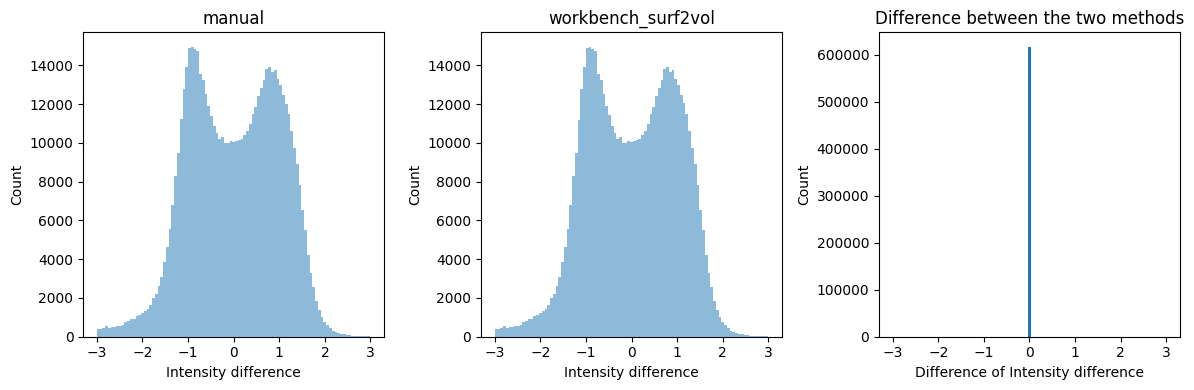

In [326]:

#this is the manual one

#manual_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/bigbrain_layer3_120um_method1_manual_raw_intensity.npz'
#workbench_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/BigBrain_voxel_up_and_down/surf_voxel_up_and_down/120um_method1/bigbrain_workbench_raw_intensity.npz'

#manual_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/bigbrain_layer3_240um_method1_manual_raw_intensity.npz'
tmp = np.load(manual_path,allow_pickle=True)
tmp_sorted_order = np.argsort(np.mean(tmp['all_values'],axis=0))
tmp_diff = np.diff(tmp['all_values'][:,tmp_sorted_order], axis=0)
tmp_diff_zscore = zscore(tmp_diff,axis=0)
tmp_raw = tmp['all_values'][:,tmp_sorted_order]
tmp_raw_zscore = zscore(tmp_raw,axis=0)
#this is workbench method
#workbench_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/BigBrain_voxel_up_and_down/surf_voxel_up_and_down/240um_method1/bigbrain_workbench_raw_intensity.npz'
tmp2 = np.load(workbench_path,allow_pickle=True)
#tmp2_sorted_order = np.argsort(np.mean(tmp2['all_values'], axis=0))
#let's order based on the order of the tmp_sorted_order
tmp2_sorted_order = tmp_sorted_order
tmp2_diff= np.diff(tmp2['all_values'][:,tmp2_sorted_order], axis=0)
tmp2_diff_zscore = zscore(tmp2_diff,axis=0)
tmp2_raw = tmp2['all_values'][:,tmp2_sorted_order]
tmp2_raw_zscore = zscore(tmp2_raw,axis=0)


data1 = tmp_raw_zscore
data2 = tmp2_raw_zscore

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
bins = np.linspace(-3, 3, 100)
#bins = np.linspace(0,2000,1000)
ax1.hist(data1.flatten(), bins=bins, alpha=0.5)
ax1.set_xlabel('Intensity difference')
ax1.set_ylabel('Count')
#ax1.set_xlim(-5,5)
ax1.set_title('manual')

ax2.hist(data2.flatten(), bins=bins, alpha=0.5)
ax2.set_xlabel('Intensity difference')
ax2.set_ylabel('Count')
#ax2.set_xlim(-5,5)
ax2.set_title('workbench_surf2vol')

ax3.hist(data2.flatten() - data1.flatten(), bins=bins)
#ax3.set_xlim(-5,5)
ax3.set_title('Difference between the two methods')
ax3.set_xlabel('Difference of Intensity difference')
ax3.set_ylabel('Count')
plt.tight_layout()
#give a super title
plt.show()


Processing raw:
Data1 shape: (19, 32492)
Data2 shape: (19, 32492)
Processing raw_zscore:
Data1 shape: (19, 32492)
Data2 shape: (19, 32492)
Processing diff:
Data1 shape: (18, 32492)
Data2 shape: (18, 32492)
Processing diff_zscore:
Data1 shape: (18, 32492)
Data2 shape: (18, 32492)


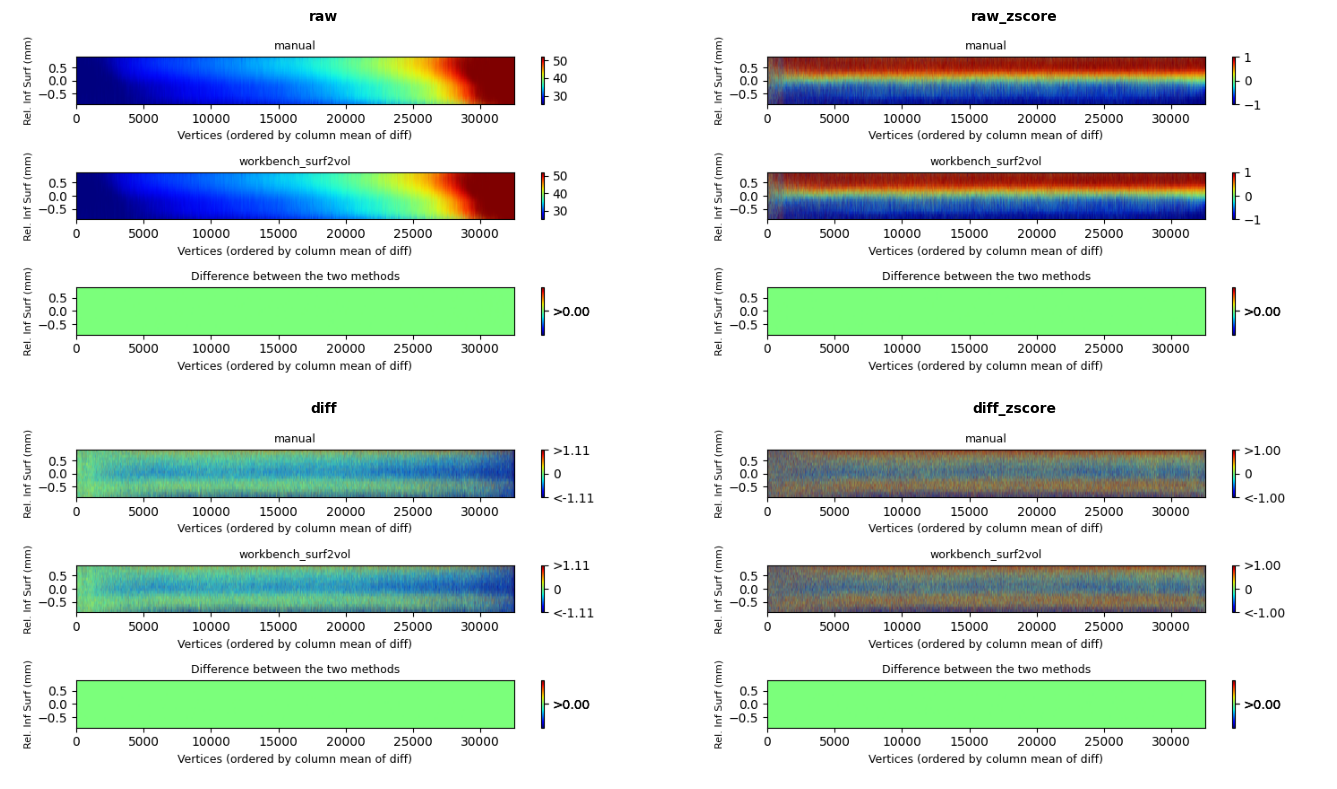

In [327]:
fontsize = 8

cmap = 'jet'
# List of all data types to process
data_types = ['raw', 'raw_zscore', 'diff', 'diff_zscore']

def get_data_by_type(data_type):
    """Return the appropriate data arrays based on data type."""
    data_map = {
        'raw': (tmp_raw, tmp2_raw),
        'raw_zscore': (tmp_raw_zscore, tmp2_raw_zscore),
        'diff': (tmp_diff, tmp2_diff),
        'diff_zscore': (tmp_diff_zscore, tmp2_diff_zscore)
    }
    return data_map[data_type]

def set_colorbar_limits(data, data_type):
    """Set appropriate colorbar limits based on data type."""
    if data_type == 'raw':
        return np.percentile(data, 10), np.percentile(data, 90)
    elif data_type == 'diff':
        p10, p90 = np.percentile(data, 10), np.percentile(data, 90)
        max_clim = round(max(abs(p10), abs(p90)), 2)
        return -max_clim, max_clim
    elif data_type in ['diff_zscore', 'raw_zscore']:
        max_clim = 1
    
    return -max_clim, max_clim

def setup_colorbar(im, ax, data_type, vmin, vmax):
    """Setup colorbar with appropriate ticks and labels."""
    cbar = plt.colorbar(im, ax=ax)
    
    if data_type in ['diff', 'diff_zscore']:
        max_clim = min(abs(vmin), abs(vmax))
        cbar.set_ticks([-max_clim, 0, max_clim])
        cbar.set_ticklabels([f'<-{max_clim:.2f}', '0', f'>{max_clim:.2f}'])
    
    return cbar

def create_subplot(ax, data, title, data_type):
    """Create a single subplot with proper formatting."""
    im = ax.imshow(data, aspect='auto', 
                   extent=[0, data.shape[1], all_dist_values[-1], all_dist_values[0]], 
                   cmap=cmap)
    
    vmin, vmax = set_colorbar_limits(data, data_type)
    im.set_clim(vmin, vmax)
    
    setup_colorbar(im, ax, data_type, vmin, vmax)
    
    ax.set_xlabel('Vertices (ordered by column mean of diff)', fontsize=fontsize+1)
    ax.set_ylabel('Rel. Inf Surf (mm)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+1)
    
    return im

# Store individual figures for later combination
individual_figures = []

# Process each data type
for data_type in data_types:
    print(f"Processing {data_type}:")
    
    # Get data arrays
    data1, data2 = get_data_by_type(data_type)
    print(f"Data1 shape: {data1.shape}")
    print(f"Data2 shape: {data2.shape}")
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))
    
    # Create first two subplots
    create_subplot(ax1, data1, 'manual', data_type)
    create_subplot(ax2, data2, 'workbench_surf2vol', data_type)
    
    # Create difference subplot
    diff_between_plots = data2 - data1
    im3 = ax3.imshow(diff_between_plots, aspect='auto', 
                     extent=[0, diff_between_plots.shape[1], all_dist_values[-1], all_dist_values[0]], 
                     cmap='jet')
    
    # Set symmetric colorbar limits for difference plot
    p10, p90 = np.nanpercentile(diff_between_plots, [10, 90])
    cmax = round(min(abs(p10), abs(p90)), 2)
    im3.set_clim(-cmax, cmax)
    
    cbar3 = plt.colorbar(im3, ax=ax3)
    cbar3.set_ticks([-cmax, 0, cmax])
    cbar3.set_ticklabels([f'<-{cmax:.2f}', '0', f'>{cmax:.2f}'])
    
    ax3.set_xlabel('Vertices (ordered by column mean of diff)', fontsize=fontsize+1)
    ax3.set_ylabel('Rel. Inf Surf (mm)', fontsize=fontsize)
    ax3.set_title('Difference between the two methods', fontsize=fontsize+1)
    
    # Add super title and display
    #fig.suptitle(f'{data_type}', fontsize=fontsize+2, y=0.98)
    plt.tight_layout()
    
    # Save individual figure
    #plt.savefig(f'{data_type}_comparison.png', dpi=300, bbox_inches='tight')
    individual_figures.append(fig)
    plt.close(fig)

# Create combined 2x2 figure
combined_fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

# Copy each individual figure to the combined figure
for i, (data_type, individual_fig) in enumerate(zip(data_types, individual_figures)):
    # Get the individual figure's canvas as an image
    individual_fig.canvas.draw()
    buf = np.frombuffer(individual_fig.canvas.buffer_rgba(), dtype=np.uint8)
    buf = buf.reshape(individual_fig.canvas.get_width_height()[::-1] + (4,))
    buf = buf[:, :, :3]  # Remove alpha channel
    
    # Display in the combined figure
    axes[i].imshow(buf)
    axes[i].set_title(f'{data_type}', fontsize=fontsize+2,fontweight='bold')
    axes[i].axis('off')

# Adjust layout and save combined figure
plt.tight_layout()
plt.savefig('combined_comparison_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

# Close individual figures to free memory
for fig in individual_figures:
    plt.close(fig)
